# Bayesian Model Combination for Star/Galaxy Classification

This notebook demonstrates an example of using Bayesian Model Combination (BMC) for the CFHTLenS data.
  Fore more details, please refer to [A Hybrid Ensemble Learning Approach to Star-Galaxy Classification](http://arxiv.org/abs/1505.02200).

In [1]:
from __future__ import print_function, division, unicode_literals
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We load the CFHTLenS data, using the object IDs as the index column.

In [2]:
df = pd.read_csv('../data/cfhtlens_matched.csv', index_col='id')

The CSV files have 100+ columns.

In [3]:
df.head()

,ALPHA_J2000,A_WORLD,BPZ_FILT,BPZ_FLAGFILT,BPZ_NONDETFILT,B_WORLD,BackGr,CHI_SQUARED_BPZ,CLASS_STAR,DELTA_J2000,...,n_exposures_detec,n_exposures_used,pos,scalelength,sp_cat,sp_cat_id,star_flag,true_class,weight,z_spec
id,,,,,,,,,,,,,,,,,,,,,
W3m0m1_11696,214.650267,0.000981,31,0,0,0.000760,0.002792,0.054,0.028628,53.106480,...,7,0,Position ICRS 214.6502668999999 53.10647969000003,0.0000,sdss-dr10,1.493031e+18,0,0,0.0000,0.202653
W3m0m1_13805,215.003288,0.000834,31,0,0,0.000602,0.011452,0.341,0.028643,53.112236,...,7,0,Position ICRS 215.00328799999977 53.1122355599...,0.0000,sdss-dr10,1.491820e+18,0,0,0.0000,0.200794
W3m0m1_14097,214.731917,0.001051,31,0,0,0.000762,0.017118,0.308,0.028655,53.108660,...,7,0,Position ICRS 214.7319170999998 53.10865952999999,0.0000,sdss-dr10,1.493029e+18,0,0,0.0000,0.114782
W3m0m1_14953,214.261103,0.000209,31,0,0,0.000175,-0.003837,0.100,0.028710,53.130319,...,7,0,Position ICRS 214.26110300000002 53.1303185000...,0.0000,sdss-dr10,5.648736e+18,0,0,0.0000,0.773710
W3m0m1_15171,214.211339,0.000205,31,0,0,0.000118,-0.004166,0.136,0.021400,53.132613,...,5,5,Position ICRS 214.21133930000028 53.1326129599...,3.1838,sdss-dr10,5.649857e+18,0,0,15.4507,0.948875


The object IDs of the training set used in the paper are stored in `clens_train_id.txt`. We used these indices to construct the same training set, since we will simply read the save results of TPC, SOMc, and HB from txt files, not run the base classifiers in this notebook.

In [4]:
train_id = pd.read_csv('../data/clens_train_id.txt')
train = df.loc[train_id.id]

test_id =pd.read_csv('../data/clens_test_id.txt')
test = df.loc[test_id.id]

It's useful to set aside the truth labels.

In [5]:
truth_train = train['true_class'].values
truth_test = test['true_class'].values

### Trees for Probabilistic Classification (TPC)

Carrasco-Kind & Brunner (2013)

TPC is a supervised machine learning technique, which is part of [Machine Learning for photo-Z (MLZ)](http://lcdm.astro.illinois.edu/static/code/mlz/MLZ-1.2/doc/html/) package.

We used XSEDE computing resources to run TPC on TACC Stampede with the following parameters (unimportant parameters are omiitted):

- Att              : u, g, r, i, z, u-g, g-r, r-i, i-z
- PredictionMode   : TPZ_C
- PredictionClass  : Class
- MinZ             : 0
- MaxZ             : 1
- NzBins           : 2
- NRandom          : 5
- NTrees           : 100
- Natt             : 3
- OobError         : yes
- MinLeaf          : 5
- ImpurityIndex    : entropy

Here, we simply load the results, Out-of-Bag (OOB) and test prediction files.

In [6]:
tpc_cv = np.loadtxt('../paper/data/clens_tpc_oob.mlz', unpack=True, usecols=(2,))
tpc_test = np.loadtxt('../paper/data/clens_tpc_test.mlz', unpack=True, usecols=(2,))

### Self-Organizing Maps Classification (SOMc)

Carrasco-Kind & Brunner (2014)

SOMc is an unsupervised machine learning technique, which is also part of [Machine Learning for photo-Z (MLZ)](http://lcdm.astro.illinois.edu/static/code/mlz/MLZ-1.2/doc/html/) package.

We used XSEDE computing resources to run SOMc on TACC Stampede with the following parameters (unimportant parameters are omiitted):

- Att              : u, g, r, i, z, u-g, g-r, r-i, i-z
- PredictionMode   : SOM
- PredictionClass  : Class
- MinZ             : 0
- MaxZ             : 1
- NzBins           : 2
- NRandom          : 10
- NTrees           : 100
- Natt             : 6
- OobError         : yes
- Topology         : sphere
- Periodic         : yes
- Ntop             : 8
- Iterations       : 200
- SomType          : online
- AlphaStart       : 0.9
- AlphaEnd         : 0.5

Here, we load the resulting Out-of-Bag (OOB) and test prediction files.

In [7]:
som_cv = np.loadtxt('../paper/data/clens_som_oob.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('../paper/data/clens_som_test.mlz', unpack=True, usecols=(2,))

### Heirarchical Bayesian Classifier (HB)

Kim, Brunner & Carrasco-Kind (2015)

In addition to supervised and unsupervised machine learning algorithms, we have also explored the use of template fitting approach to photometric classification. Following a similar approach to Fadely et al. (2012), we have developed a Hierarchical Bayesian (HB) template fitting routine. In HB template fitting approach, there is no need for additional knowledge outside the observed data and the template SEDs, because the entire sample of sources is used to infer the prior probabilities for each individual source.

One of the main ideas of HB is to introduce the hyperparameter $\mathbf{ϴ}$ to write the probability that a source is a galaxy (or a star) given the observed data $\mathbf{D}$ as

\begin{equation}
P \left( G | \mathbf{D} \right)
= P \left( \mathbf{D} | G, \mathbf{\theta} \right)
P \left( G | \mathbf{\theta} \right)
\end{equation}

The hyperparameter is a nuisance parameter is essentially the misclassification probability that characterizes our uncertainty in the prior distributions. To compute the likelihood that a source is a galaxy, we marginalize over all possible templates:

\begin{equation}
P \left( \mathbf{D} | G, \mathbf{\theta} \right)
= \sum_{j}
P \left( \mathbf{D} | t_j, G \right)
P \left( t_j | G, \mathbf{\theta} \right)
\end{equation}

The likelihood of each template is again marginalized over the Gaussian uncertainty in the template-fitting coefficient. Furthermore, for galaxy templates, we introduce another step that marginalizes the likelihood by letting a given galaxy template to be redshifted by a factor of $1+z$. To specify a prior distribution for the fit amplitude, we adopt a flat, uninformative prior distribution across redshifts. Finally, we find the hyperparameters by optimizing the total marginalized likelihood, or sample the posterior probability distribution in the hyperparameter space (with `HGSGC.optimize()`, we can also find the hyperparameters by optmizing the total marginalized likelihood).

Although the previous HB star/galaxy classifier by Fadely et al. simply optimized the hyperparameters, our fully parallized implementaion can also sample the hyperparameter space using a Markov Chain Monte Carlo (MCMC) sampler (Foreman-Mackey et al. 2013) using `HBSGC.sample()`.

In [8]:
hbc_all = np.loadtxt('../paper/data/clens_all.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:len(train)]
hbc_test = hbc_all[len(train):]

### Morphological classification

As a first-order morphological selection of point sources, we adopt a rectangluar cut in the half-light radius ($r_h$) vs. magnitude plane, popular among the weak lensing community (Kaiser et al. 1995). We inspect the $r_h$ vs. magnitude diagram visually to determine the cut values.

In [9]:
r_h_cv = train.FLUX_RADIUS.values
mag_i_cv = train.MAG_i.values

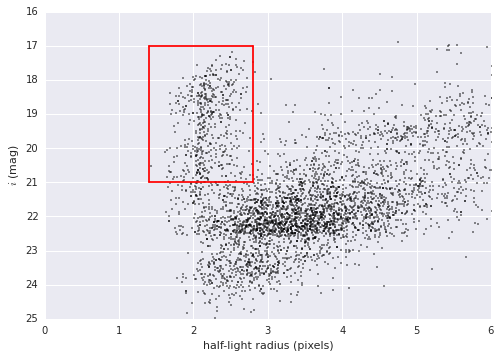

In [10]:
mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

# select a subset to make the plot not too crowded
rows = np.random.choice(xrange(len(r_h_cv)), size=5000)
plt.scatter(r_h_cv[rows], mag_i_cv[rows], marker='.', s=5, color='k')
plt.xlabel('half-light radius (pixels)')
plt.ylabel(r'$i$ (mag)')
plt.xlim(0, 6)
plt.ylim(16, 25)
plt.ylim(plt.ylim()[::-1])

plt.plot([r_h_upper, r_h_upper], [mag_i_lower, mag_i_upper], c = 'r')
plt.plot([r_h_lower, r_h_lower], [mag_i_lower, mag_i_upper], c = 'r')
plt.plot([r_h_lower, r_h_upper], [mag_i_upper, mag_i_upper], c = 'r')
plt.plot([r_h_upper, r_h_lower], [mag_i_lower, mag_i_lower], c = 'r')

plt.show()

A morphological classifier is simple to implement:

In [11]:
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

In [12]:
morph_cv = morph_class(mag_i_cv, r_h_cv, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

We use the same morphological classifier to separate stars from galaxies in the test set.

In [13]:
r_h_test = test.FLUX_RADIUS.values
mag_i_test = test.MAG_i.values

morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

### Bayesian Model Combination

Kim, Brunner & Carrasco-Kind (2015)

Collectively, these four methods may represent almost all standard star/galaxy classification approaches published in the literature. It is very likely that any new classification technique would be functionally similar to one of these methods. Therefore, any of these methods could in principle be replaced by a similar method. At this point, there remains the challenge of finding optimal ways to combine our existing implementations.

Bayesian Model Combination (BMC) uses Bayesian principles to generate an ensemble combination of different classifiers (Monteith et al. 2011). The probability that a source is a galaxy (or a star) is given by

\begin{equation}
P \left( G | X, \mathbf{D}, \mathbf{M}, \mathbf{E} \right) =
\sum_{e \in \mathbf{E}}
P \left( G | X, \mathbf{M}, e \right)
P \left( e | \mathbf{D} \right)
\end{equation}

where $e$ is an element in the ensemble space $\mathbf{E}$ of possible model combinations. By Bayes' Theorem, the posterior probability of $e$ given $\mathbf{D}$ can be calculated by using

\begin{equation}
P \left( e | \mathbf{D} \right) =
\frac{ P \left(e\right) }{ P \left( \mathbf{D} \right) }
\prod_{i=1}^{n}
P \left( d_i | e \right)
\propto P \left( e \right)
\prod_{i=1}^{n} P \left( d_i | e \right)
\end{equation}

Although the space $\mathbf{E}$ of potential model combinations is in principle infinite, it can easily be sampled from in order to produce a reasonable finite set of potential model combinations to test.

In our implementation, weights for the first $q$ combinations were drawn from a Dirichlet distribution with uniform alpha values. The posterior probability of a model combination is then calculated for each combination, and the weights from the most probable combination were used to update the alpha values for the distribution from which the next $q$ weight assignments were drawn.

First, we import the `bmc` module.

In [14]:
import bmc

We need the magnitude, magnitude errors, and colors for BMC.

In [15]:
mags = ['MAG_u', 'MAG_g', 'MAG_r', 'MAG_i', 'MAG_z']
magerrs = ['MAGERR_u', 'MAGERR_g', 'MAGERR_r', 'MAGERR_i', 'MAGERR_z']
colors = ['u-g', 'g-r', 'r-i', 'i-z']

We calculate colors and impute bad/missing values (-99, 99) with the mean values of each field.

In [16]:
def impute_mags(df, mags=None, magerrs=None):
    bad_values = [-99, 99]
    df[mags + magerrs] = df[mags + magerrs].replace(bad_values, [np.nan] * len(bad_values))
    return df.fillna(df[mags + magerrs].mean())

def perturb_mags(df, mags=None, magerrs=None):
    for m, merr in zip(mags, magerrs):
        # set replace merr = 0 with a very small value. necessary to avoid numpy scale == 0 error.
        df[merr].where(df[merr] > 0, 1.0e-100, inplace=True)
        df[m] = np.random.normal(df[m].values, df[merr].values)
    return df

def calc_colors(df, colors=None):
    for c in colors:
        df[c] = df['MAG_' + c[0]] - df['MAG_' + c[2]]
    for c in colors:
        df[c].where(df[c] < 4, np.nan, inplace = True)
        df[c].where(df[c] > -1, np.nan, inplace = True)
    df[colors] = df[colors].fillna(df[colors].mean())
    return df

train = impute_mags(train, mags=mags, magerrs=magerrs)
train = calc_colors(train, colors=colors)

test = impute_mags(test, mags=mags, magerrs=magerrs)
test = calc_colors(test, colors=colors)

The class object is unimaginatively named `BMC`.

In [17]:
clf = bmc.BMC()

We use only the cross-validation data to calculate the weights. The `fit()` function needs the truth labels for each cross-validation data points (the `truth_train` array). When the "training" is done, it prints out

    Done creating SOM map.

In [18]:
base_cv = np.vstack((tpc_cv, som_cv, hbc_cv, morph_cv)).T
clf.fit(train[mags + colors].values, base_cv, truth_train)

Done creating SOM map.


Now we apply the weights to the predictions of each classifier. Note that the truth labels (the `truth_test` array) is not used in the `predict_proba()` function.

In [19]:
base_test = np.vstack((tpc_test, som_test, hbc_test, morph_test)).T
clf_test = clf.predict_proba(test[mags + colors].values, base_test)

To visualize the SOM projections, let's choose some colors from Seaborn's color pallete.

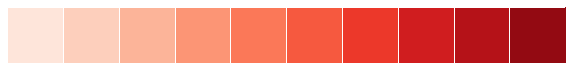

In [20]:
cmap1 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

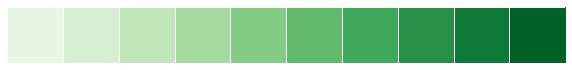

In [21]:
cmap2 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

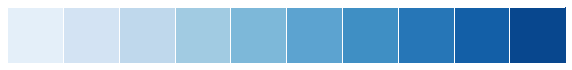

In [22]:
cmap3 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

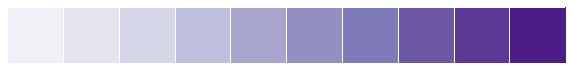

In [23]:
cmap4 = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

The hybrid `BMC` algorithm creates a SOM cell. These cells are stored in the `cells` directory.

In [24]:
from matplotlib import gridspec

n_grid = 10
clens_som_cell = np.load('cells/cv_cells.0.npy')

# calculate mean values for each cell

def calc_cell_mean(x, som_cells, n_grid):
    x_cells = np.zeros(n_grid**2)
    for i in xrange(n_grid**2):
        i_cell = np.where(som_cells == i)
        x_cells[i] = x[i_cell].mean()
    
    return x_cells.reshape((n_grid, n_grid))

mag_i_cells = calc_cell_mean(train['MAG_i'].values, clens_som_cell, 10)
clr_u_g_cells = calc_cell_mean(train['u-g'].values, clens_som_cell, 10)
clr_g_r_cells = calc_cell_mean(train['g-r'].values, clens_som_cell, 10)
star_frac_cells = calc_cell_mean(truth_train, clens_som_cell, 10)

We plot a two-dimensional 10×10 SOM representation showing the mean $i$-band magnitude (top left), the fraction of true stars in each cell (top right), and the mean values of $u−g$ (bottom left) and $g−r$ (bottom right) for the cross-validation data.

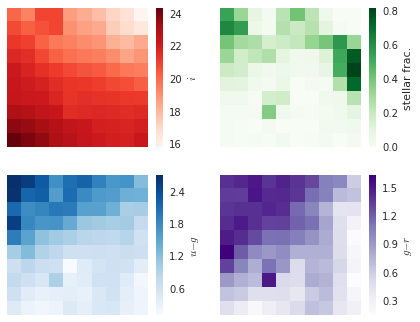

In [25]:
gs = gridspec.GridSpec(2, 3, height_ratios = (1, 1), width_ratios = (9, 9, 1))

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.matshow(mag_i_cells, cmap=cmap1)
ax1.set_xticks([])
ax1.set_yticks([])
cb1 = plt.colorbar(im1)
cb1.set_ticks([16, 18, 20, 22, 24])
cb1.set_label(r'$i$')

ax2 = plt.subplot(gs[0, 1])
im2 = ax2.matshow(star_frac_cells, cmap=cmap2)
ax2.set_xticks([])
ax2.set_yticks([])
cb2 = plt.colorbar(im2)
cb2.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cb2.set_label('stellar frac.')

ax3 = plt.subplot(gs[1, 0])
im3 = ax3.matshow(clr_u_g_cells, cmap=cmap3)
ax3.set_xticks([])
ax3.set_yticks([])
cb3 = plt.colorbar(im3)
cb3.set_ticks([0, 0.6, 1.2, 1.8, 2.4])
cb3.set_label(r'$u-g$')

ax4 = plt.subplot(gs[1, 1])
im4 = ax4.matshow(clr_g_r_cells, cmap=cmap4)
ax4.set_xticks([])
ax4.set_yticks([])
cb4 = plt.colorbar(im4)
cb4.set_label(r'$g-r$')
cb4.set_ticks([0.3, 0.6, 0.9, 1.2, 1.5])

plt.show()

The relative weights are stored in the `weights` directory. Using the weights, we also plot a two-dimensional 10×10 SOM representation showing the relative weights.

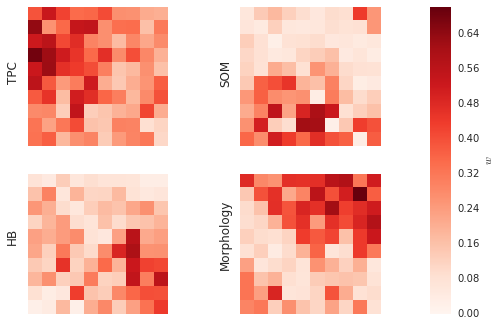

In [26]:
tpc_cells = np.zeros(n_grid**2)
som_cells = np.zeros(n_grid**2)
hbc_cells = np.zeros(n_grid**2)
morph_cells = np.zeros(n_grid**2)

for i in xrange(n_grid**2):
    
    weights = np.load('weights/bmc_weights.0.' + str(i) + '.npy')

    w = np.sum(weights, axis = 0)
    w = w / w.sum()

    tpc_cells[i] = w[0]
    som_cells[i] = w[1]
    hbc_cells[i] = w[2]
    morph_cells[i] = w[3]

tpc_cells = tpc_cells.reshape((n_grid, n_grid))
som_cells = som_cells.reshape((n_grid, n_grid))
hbc_cells = hbc_cells.reshape((n_grid, n_grid))
morph_cells = morph_cells.reshape((n_grid, n_grid))

gs = gridspec.GridSpec(2, 3, height_ratios = (1, 1), width_ratios = (9, 9, 1))

vmax = np.max([tpc_cells, som_cells, hbc_cells, morph_cells])
rotation = 'vertical'

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.matshow(tpc_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax1.set_title('TPC', rotation = rotation, x = -0.1, y = 0.5)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(gs[0, 1])
ax2.matshow(som_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax2.set_title('SOM', rotation = rotation, x = -0.1, y = 0.5)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = plt.subplot(gs[1, 0])
ax3.matshow(hbc_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax3.set_title('HB', rotation = rotation, x = -0.1, y = 0.5)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.subplot(gs[1, 1])
ax4.matshow(morph_cells, vmin=0, vmax=vmax, cmap=cmap1)
ax4.set_title('Morphology', rotation = rotation, x = -0.1, y = 0.7)
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = plt.subplot(gs[0:, 2])
cb1 = plt.colorbar(im1, cax=ax5)
cb1.set_label(r'$w$')
cb1.set_clim([0, vmax])

plt.show()

## Rerferences

Fadely R., Hogg D. W., Willman B., 2012, ApJ, 760, 15

Foreman-Mackey D., Hogg D. W., Lang D., Goodman J., 2013, PASP, 125, 306

Hildebrandt H. et al., 2012, MNRAS, 421, 2355

Kaiser N., Squires G., Broadhurst T., 1995, ApJ, 449, 460

Le Fevre O. et al., 2005, A&A, 439, 845

Monteith K., Carroll J. L., Seppi K., Martinez T., 2011, in Neural Networks (IJCNN), The 2011 International Joint Conference on, IEEE, pp. 2657–2663